In [ ]:
import os 
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
from PIL import Image 

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

import random

# from posteriors import Diffusion_Coefficients, BrownianPosterior_Coefficients, get_time_schedule
from sampling_utils import extract

ASBM训练:

$x_0 \sim p_{data}$

$x_1 \sim p_{prior}$

$\varepsilon$ 是布朗桥强度

整体上分为两步

1.从$x_0$和$x_1$的联合分布中采样$(x_0, x_1)$, 然后得出条件化的布朗桥
$$
p^{W^\varepsilon}(x_{t_1}\ldots x_{t_N} | x_0, x_1) = \prod_{i=1}^{N} p^{W^\varepsilon}(x_{t_i} | x_{t_{i-1}}, x_1) \\
p^{W^\varepsilon}(x_{t_i} | x_{t_{i-1}}, x_1) = \mathcal{N}(x_{t_i}; x_{t_{i-1}} + \frac{t_i - t_{i-1}}{1 - t_{i-1}}(x_1 - x_{t_{i-1}}),\varepsilon \frac{(t_i - t_{i-1})(1 - t_i)}{(1 - t_{i-1})} I)\\
p^{W^\varepsilon}(x_{t_{i}} | x_{t_{i+1}}, x_1) = \mathcal{N}(x_{t_i}; \frac{t_{i+1}-t_{i}}{t_{i+1}} x_0 + \frac{t_{i}}{t_{i+1}} x_{t_{i+1}},\varepsilon \frac{t_i(t_{i+1} - t_{i})}{t_{i+1}} I)\\
p^{W^\varepsilon}(x_{t_N} | x_0, x_1) = \mathcal{N}(x_{t_N}; (1 - t_N) x_0 + t_N x_1, \varepsilon t_N(1 - t_N) I)
$$


In [ ]:
class BrownianPosterior_Coefficients():
    def __init__(self, args, device):
        epsilon = args.epsilon
        self.epsilon = epsilon
        print(f"BrownianPosterior with epsilon {epsilon} and num steps {args.num_timesteps}")
        num_timesteps = args.num_timesteps

        t = torch.linspace(0, 1, num_timesteps+1, device=device)
        self.posterior_mean_coef1 = 1 - t[:-1]/t[1:]
        self.posterior_mean_coef2 = t[:-1]/t[1:]

        self.posterior_variance = epsilon*t[:-1]*(t[1:] - t[:-1])/t[1:]
        self.posterior_log_variance_clipped = torch.log(self.posterior_variance.clamp(min=1e-20))

In [ ]:
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
import math

class Checkerboard(Dataset):
    def __init__(self, size=8, grid_size=4):
        self.size = size
        self.grid_size = grid_size
        self.checkboard = torch.tensor([[i, j] for i in range(grid_size) for j in range(grid_size) if (i + j) % 2 == 0])

        grid_pos = torch.randint(low=0, high=self.checkboard.shape[0], size=(self.size,), dtype=torch.int64)
        self.data = torch.rand(size=(self.size, 2), dtype=torch.float32) + self.checkboard[grid_pos].float()
        self.data = self.data / self.grid_size * 2 - 1

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return self.data[idx]


class Pinwheel(Dataset):
    def __init__(self, npar: int):
        self.size = npar

        radial_std = 0.3
        tangential_std = 0.1
        num_classes = 7
        num_per_class = math.ceil(npar / num_classes)
        rate = 0.25
        rads = np.linspace(0, 2 * np.pi, num_classes, endpoint=False)

        features = np.random.randn(num_classes*num_per_class, 2) \
            * np.array([radial_std, tangential_std])
        features[:, 0] += 1.
        labels = np.repeat(np.arange(num_classes), num_per_class)

        angles = rads[labels] + rate * np.exp(features[:, 0])
        rotations = np.stack([np.cos(angles), -np.sin(angles), np.sin(angles), np.cos(angles)])
        rotations = np.reshape(rotations.T, (-1, 2, 2))
        x = .4 * np.random.permutation(np.einsum("ti,tij->tj", features, rotations))

        self.init_sample = torch.from_numpy(x).float()

    def __len__(self):
        return self.size

    def __getitem__(self, idx: int) -> Tensor:
        return self.init_sample[idx]


data_size = 2 ** 20
pinwheel_dataset = Pinwheel(data_size)
checkerboard_dataset = Checkerboard(size=data_size, grid_size=8)

In [ ]:
batch_size = 2 ** 10
pinwheel_data_loader = DataLoader(pinwheel_dataset, batch_size, num_workers=0, pin_memory=True, shuffle=True)
checkerboard_data_loader = DataLoader(checkerboard_dataset, batch_size, num_workers=0, pin_memory=True, shuffle=True)

def show_2d_data(data: Tensor):
    plt.figure(figsize=(3, 3))
    plt.scatter(data[:, 0], data[:, 1])
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)

    plt.show()
    plt.close()

In [ ]:
pinwheel_batch = next(iter(pinwheel_data_loader))
checkerboard_batch = next(iter(checkerboard_data_loader))

In [ ]:
show_2d_data(next(iter(pinwheel_data_loader)))
show_2d_data(next(iter(checkerboard_data_loader)))

接下来需要一个统一的DataLoader，返回一个Batch的(x,y)配对数据，作为从联合分布q采样的工具

In [ ]:
class PairedDataset(Dataset):
    """
    为 SB 训练提供成对样本 (x0, x1)：
      x0 ~ target_ds (p0),  x1 ~ source_ds (p1)
    pairing:
      - "independent": 每次各自随机取一个（独立耦合，默认）
      - "aligned":     用相同索引配对（便于可复现/调试）
    """
    def __init__(self, target_ds: Dataset, source_ds: Dataset, pairing: str = "independent"):
        self.target_ds = target_ds
        self.source_ds = source_ds
        self.pairing = pairing
        self.len = max(len(target_ds), len(source_ds))

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        if self.pairing == "aligned":
            i0 = idx % len(self.target_ds)
            i1 = idx % len(self.source_ds)
        else:  # independent
            i0 = random.randint(0, len(self.target_ds) - 1)
            i1 = random.randint(0, len(self.source_ds) - 1)
        x0 = self.target_ds[i0]   # Tensor [..., 2]
        x1 = self.source_ds[i1]   # Tensor [..., 2]
        return x0, x1

接下来的训练，我们要能做到以下几个能力
1. 给定$x_0, x_1\sim q(x_0,x_1)$ （这里直接假设独立）, 构造 $(x_t, x_{t+1})$ 作为布朗桥ground truth, 先按$q(x_{t+1}| x_0, x_1)$采样$x_{t+1}$，再按$q(x_t|x_{t+1}, x_0)$采样$x_{t}$
2. 生成器：给定$(x_t,t)$， 预测 $x_0$
3. 判别器：给定$(x_t, x_{t+1})$，判断是不是由生成器生成的

In [ ]:
def sample_posterior(coefficients, x0, x_tp1, t_idx):
    """
    Brownian-bridge one-step posterior:
    Sample x_t ~ q(x_t | x_{t+1}=x_tp1, x_0=x0) for discrete index t_idx in {0,...,N-1}.
    coefficients: BrownianPosterior_Coefficients (has posterior_mean_coef1/2, posterior_log_variance_clipped)
    x0, x_tp1: (B, D)
    t_idx: (B,) int64
    """
    assert t_idx.dtype in (torch.int32, torch.int64), "t_idx must be integer indices"
    a_t = extract(coefficients.posterior_mean_coef1, t_idx, x_tp1.shape)  # coef for x0
    b_t = extract(coefficients.posterior_mean_coef2, t_idx, x_tp1.shape)  # coef for x_{t+1}
    mean = a_t * x0 + b_t * x_tp1
    log_var = extract(coefficients.posterior_log_variance_clipped, t_idx, x_tp1.shape)

    noise = torch.randn_like(x_tp1)
    nonzero_mask = (1 - (t_idx == 0).float())
    while len(nonzero_mask.shape) < len(mean.shape):
        nonzero_mask = nonzero_mask.unsqueeze(-1)
    return mean + nonzero_mask * torch.exp(0.5 * log_var) * noise


def sample_bridge(coefficients, x0, x1, tau):
    """
    Brownian bridge marginal:
    Sample X_tau ~ N( (1-tau)x0 + tau x1,  epsilon * tau * (1 - tau) I ), where tau in [0,1].
    tau: (B,1) or (B,) float in [0,1]
    """
    if tau.ndim == 1:
        tau = tau.unsqueeze(-1)
    assert tau.dtype.is_floating_point, "tau must be float in [0,1]"
    mean = (1. - tau) * x0 + tau * x1
    var = coefficients.epsilon * tau * (1. - tau)
    log_var = torch.log(var.clamp_min(1e-20))
    noise = torch.randn_like(x0)

    # turn off noise exactly at endpoints tau=0 or tau=1
    nonzero_mask = (1. - (tau.eq(0.).float())) * (1. - (tau.eq(1.).float()))
    return mean + nonzero_mask * torch.exp(0.5 * log_var) * noise


def sample_pair_condition(coefficients, x0, x1, t_idx):
    """
    Build a real pair (x_t, x_{t+1}) given endpoints (x0, x1) and discrete index t_idx in {0,...,N-1}.
    Steps:
      1) tau_{t+1} = (t_idx+1)/N, sample x_{t+1} from bridge marginal
      2) sample x_t from one-step posterior q(x_t | x_{t+1}, x0)
    """
    assert t_idx.dtype in (torch.int32, torch.int64)
    N = coefficients.posterior_mean_coef1.shape[0]  # N steps
    tau_tp1 = (t_idx.to(torch.float32) + 1.) / float(N)  # (B,)
    x_tp1 = sample_bridge(coefficients, x0, x1, tau_tp1)           # (B, D)
    x_t   = sample_posterior(coefficients, x0, x_tp1, t_idx)       # (B, D)
    return x_t, x_tp1


现在是判别器和生成器

In [ ]:
class MyGenerator(nn.Module):
    def __init__(
        self, x_dim, t_dim, n_t, z_dim, out_dim, layers=[128, 128, 128],
        active=partial(nn.LeakyReLU, 0.2),
    ):
        super().__init__()

        self.x_dim = x_dim
        self.t_dim = t_dim
        self.z_dim = z_dim

        self.model_list = []
        ch_prev = x_dim + t_dim + z_dim

        self.t_transform = nn.Embedding(n_t, t_dim,)

        for ch_next in layers:
            self.model_list.append(nn.Linear(ch_prev, ch_next))
            self.model_list.append(active())
            ch_prev = ch_next

        self.model_list.append(nn.Linear(ch_prev, out_dim))
        self.model = nn.Sequential(*self.model_list)

    def forward(self, x, t, z):
        batch_size = x.shape[0]

        if z.shape != (batch_size, self.z_dim):
            z = z.reshape((batch_size, self.z_dim))

        return self.model(
            torch.cat([
                x,
                self.t_transform(t),
                z,
            ], dim=1)
        )


class MyDiscriminator(nn.Module):
    def __init__(
        self, x_dim, t_dim, n_t, layers=[128, 128, 128],
        active=partial(nn.LeakyReLU, 0.2),
    ):
        super().__init__()

        self.x_dim = x_dim
        self.t_dim = t_dim

        self.model_list = []
        ch_prev = 2 * x_dim + t_dim

        self.t_transform = nn.Embedding(n_t, t_dim,)
        
        for ch_next in layers:
            # print(f"Build layer from {ch_prev} to {ch_next}")
            self.model_list.append(nn.Linear(ch_prev, ch_next))
            self.model_list.append(active())
            ch_prev = ch_next

        self.model_list.append(nn.Linear(ch_prev, 1))
        self.model = nn.Sequential(*self.model_list)

    def forward(self, x_t, t, x_tp1,):
        transform_t = self.t_transform(t)
        # print(f"x_t.shape = {x_t.shape}, transform_t = {transform_t.shape}, x_tp1 = {x_tp1.shape}")

        return self.model(
            torch.cat([
                x_t,
                transform_t,
                x_tp1,
            ], dim=1)
        ).squeeze()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

必要的参数
1. Batch size
2. learning rate: lr_d, lr_g
3. optimizer: Adam beta1, beta2
4. epoch
5. epsilon
6. x_dim, 数据维度
7. t_dim, 时间维度
8. z_dim, 隐空间维度

Namespace(batch_size=4096, lr_d=0.0002, lr_g=0.0002, beta1=0.5, beta2=0.9, epoch=50, epsilon=0.5, x_dim=2, t_dim=4, z_dim=1, num_timesteps=4, seed=42, output_dir='./output', use_minibatch_ot=False)
BrownianPosterior with epsilon 0.5 and num steps 4
=> loaded checkpoint (iteration 20480)
Start training ASBM...
[Iter 20600] D=1.3794 (real 0.6825 fake 0.6964 r1 0.0005) | G=0.6941
Checkpoint saved @ epoch 1
[Iter 20800] D=1.3806 (real 0.7035 fake 0.6764 r1 0.0007) | G=0.7108
Checkpoint saved @ epoch 2
[Iter 21000] D=1.3835 (real 0.6932 fake 0.6896 r1 0.0008) | G=0.6956
[Iter 21200] D=1.3865 (real 0.6924 fake 0.6934 r1 0.0007) | G=0.6926
Checkpoint saved @ epoch 3
[Iter 21400] D=1.3875 (real 0.6926 fake 0.6940 r1 0.0009) | G=0.6920
Checkpoint saved @ epoch 4
[Iter 21600] D=1.3847 (real 0.6923 fake 0.6917 r1 0.0007) | G=0.6966
Checkpoint saved @ epoch 5
[Iter 21800] D=1.3876 (real 0.6852 fake 0.7018 r1 0.0006) | G=0.6858
[Iter 22000] D=1.3870 (real 0.6882 fake 0.6982 r1 0.0006) | G=0.6901


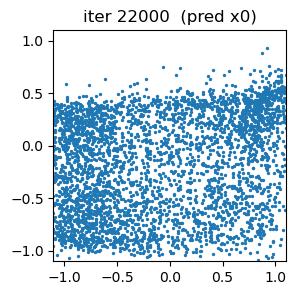

Checkpoint saved @ epoch 6
[Iter 22200] D=1.3885 (real 0.6967 fake 0.6913 r1 0.0006) | G=0.6941
Checkpoint saved @ epoch 7
[Iter 22400] D=1.3855 (real 0.6918 fake 0.6932 r1 0.0005) | G=0.6961
Checkpoint saved @ epoch 8
[Iter 22600] D=1.3869 (real 0.6862 fake 0.6998 r1 0.0008) | G=0.6889
Checkpoint saved @ epoch 9
[Iter 22800] D=1.3856 (real 0.6978 fake 0.6873 r1 0.0005) | G=0.7008
[Iter 23000] D=1.3855 (real 0.6873 fake 0.6977 r1 0.0005) | G=0.6879
Checkpoint saved @ epoch 10
[Iter 23200] D=1.3864 (real 0.6884 fake 0.6976 r1 0.0004) | G=0.6937
Checkpoint saved @ epoch 11
[Iter 23400] D=1.3820 (real 0.6939 fake 0.6876 r1 0.0005) | G=0.7014
Checkpoint saved @ epoch 12
[Iter 23600] D=1.3841 (real 0.6935 fake 0.6902 r1 0.0004) | G=0.6994
[Iter 23800] D=1.3842 (real 0.6947 fake 0.6891 r1 0.0004) | G=0.6965
Checkpoint saved @ epoch 13
[Iter 24000] D=1.3842 (real 0.6938 fake 0.6895 r1 0.0009) | G=0.6961


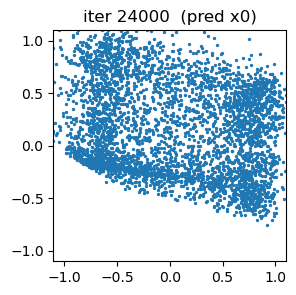

Checkpoint saved @ epoch 14
[Iter 24200] D=1.3878 (real 0.6968 fake 0.6907 r1 0.0002) | G=0.6991
Checkpoint saved @ epoch 15
[Iter 24400] D=1.3869 (real 0.6875 fake 0.6992 r1 0.0002) | G=0.6886
Checkpoint saved @ epoch 16
[Iter 24600] D=1.3819 (real 0.6806 fake 0.7006 r1 0.0007) | G=0.6868
[Iter 24800] D=1.3896 (real 0.6958 fake 0.6931 r1 0.0007) | G=0.6931
Checkpoint saved @ epoch 17
[Iter 25000] D=1.3819 (real 0.6854 fake 0.6956 r1 0.0010) | G=0.6947
Checkpoint saved @ epoch 18
[Iter 25200] D=1.3846 (real 0.6871 fake 0.6969 r1 0.0005) | G=0.6905
Checkpoint saved @ epoch 19
[Iter 25400] D=1.3853 (real 0.6944 fake 0.6904 r1 0.0004) | G=0.6954
[Iter 25600] D=1.3855 (real 0.6854 fake 0.6998 r1 0.0003) | G=0.6883
Checkpoint saved @ epoch 20
[Iter 25800] D=1.3937 (real 0.7074 fake 0.6859 r1 0.0003) | G=0.7043
Checkpoint saved @ epoch 21
[Iter 26000] D=1.3850 (real 0.6990 fake 0.6856 r1 0.0004) | G=0.6997


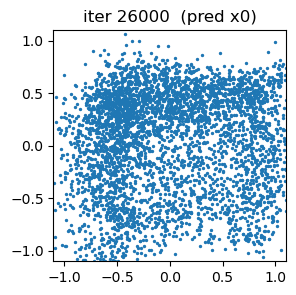

Checkpoint saved @ epoch 22
[Iter 26200] D=1.3829 (real 0.6875 fake 0.6951 r1 0.0003) | G=0.6948
Checkpoint saved @ epoch 23
[Iter 26400] D=1.3848 (real 0.6903 fake 0.6939 r1 0.0005) | G=0.6933
[Iter 26600] D=1.3877 (real 0.6966 fake 0.6907 r1 0.0004) | G=0.6957
Checkpoint saved @ epoch 24
[Iter 26800] D=1.3833 (real 0.6807 fake 0.7023 r1 0.0003) | G=0.6893
Checkpoint saved @ epoch 25
[Iter 27000] D=1.3817 (real 0.7049 fake 0.6765 r1 0.0003) | G=0.7085
Checkpoint saved @ epoch 26
[Iter 27200] D=1.3843 (real 0.6732 fake 0.7110 r1 0.0001) | G=0.6762
Checkpoint saved @ epoch 27
[Iter 27400] D=1.3875 (real 0.7005 fake 0.6868 r1 0.0002) | G=0.6980
[Iter 27600] D=1.3878 (real 0.7005 fake 0.6871 r1 0.0002) | G=0.7040
Checkpoint saved @ epoch 28
[Iter 27800] D=1.3850 (real 0.6854 fake 0.6994 r1 0.0002) | G=0.6893
Checkpoint saved @ epoch 29
[Iter 28000] D=1.3844 (real 0.6921 fake 0.6920 r1 0.0003) | G=0.6978


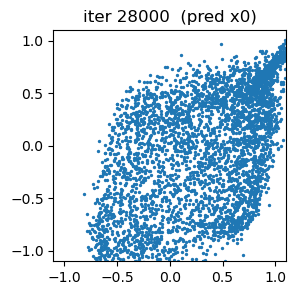

Checkpoint saved @ epoch 30
[Iter 28200] D=1.3874 (real 0.6879 fake 0.6993 r1 0.0003) | G=0.6922
[Iter 28400] D=1.3864 (real 0.6821 fake 0.7042 r1 0.0001) | G=0.6822
Checkpoint saved @ epoch 31
[Iter 28600] D=1.3859 (real 0.6998 fake 0.6859 r1 0.0002) | G=0.7008
Checkpoint saved @ epoch 32
[Iter 28800] D=1.3847 (real 0.6988 fake 0.6857 r1 0.0002) | G=0.7000
Checkpoint saved @ epoch 33
[Iter 29000] D=1.3876 (real 0.6911 fake 0.6964 r1 0.0002) | G=0.6896
Checkpoint saved @ epoch 34
[Iter 29200] D=1.3874 (real 0.7037 fake 0.6836 r1 0.0001) | G=0.7030
[Iter 29400] D=1.3862 (real 0.7020 fake 0.6841 r1 0.0001) | G=0.7020
Checkpoint saved @ epoch 35
[Iter 29600] D=1.3848 (real 0.6860 fake 0.6986 r1 0.0003) | G=0.6890
Checkpoint saved @ epoch 36
[Iter 29800] D=1.3836 (real 0.6870 fake 0.6964 r1 0.0002) | G=0.6914
Checkpoint saved @ epoch 37
[Iter 30000] D=1.3847 (real 0.6837 fake 0.7008 r1 0.0002) | G=0.6893


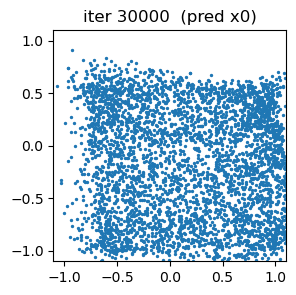

[Iter 30200] D=1.3879 (real 0.6901 fake 0.6977 r1 0.0002) | G=0.6878
Checkpoint saved @ epoch 38
[Iter 30400] D=1.3859 (real 0.6983 fake 0.6875 r1 0.0001) | G=0.6994
Checkpoint saved @ epoch 39
[Iter 30600] D=1.3839 (real 0.6966 fake 0.6870 r1 0.0003) | G=0.6984
Checkpoint saved @ epoch 40
[Iter 30800] D=1.3855 (real 0.6912 fake 0.6942 r1 0.0002) | G=0.6922
Checkpoint saved @ epoch 41
[Iter 31000] D=1.3885 (real 0.6878 fake 0.7006 r1 0.0001) | G=0.6853
[Iter 31200] D=1.3865 (real 0.7022 fake 0.6842 r1 0.0002) | G=0.7047
Checkpoint saved @ epoch 42
[Iter 31400] D=1.3859 (real 0.6872 fake 0.6985 r1 0.0001) | G=0.6885
Checkpoint saved @ epoch 43
[Iter 31600] D=1.3882 (real 0.7022 fake 0.6858 r1 0.0001) | G=0.7019
Checkpoint saved @ epoch 44
[Iter 31800] D=1.3841 (real 0.7055 fake 0.6786 r1 0.0001) | G=0.7089
[Iter 32000] D=1.3882 (real 0.6963 fake 0.6918 r1 0.0002) | G=0.6962


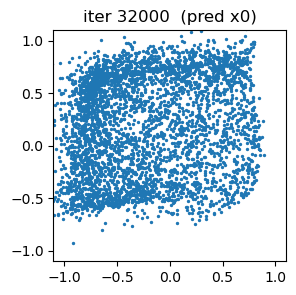

Checkpoint saved @ epoch 45
[Iter 32200] D=1.3878 (real 0.6961 fake 0.6916 r1 0.0002) | G=0.6970
Checkpoint saved @ epoch 46
[Iter 32400] D=1.3863 (real 0.6865 fake 0.6998 r1 0.0001) | G=0.6872
Checkpoint saved @ epoch 47
[Iter 32600] D=1.3841 (real 0.6917 fake 0.6923 r1 0.0001) | G=0.6942
Checkpoint saved @ epoch 48
[Iter 32800] D=1.3858 (real 0.6996 fake 0.6860 r1 0.0001) | G=0.6978
[Iter 33000] D=1.3852 (real 0.6958 fake 0.6894 r1 0.0001) | G=0.6968
Checkpoint saved @ epoch 49
[Iter 33200] D=1.3876 (real 0.6938 fake 0.6937 r1 0.0001) | G=0.6942
Checkpoint saved @ epoch 50


In [121]:
from typing import Optional


def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def parse_args(usedefault:bool = False):
    import argparse
    parser = argparse.ArgumentParser()
    parser.add_argument('--batch_size', type=int, default=2**10)
    parser.add_argument('--lr_d', type=float, default=2e-4)
    parser.add_argument('--lr_g', type=float, default=2e-4)
    parser.add_argument('--beta1', type=float, default=0.5)
    parser.add_argument('--beta2', type=float, default=0.9)
    parser.add_argument('--epoch', type=int, default=50)
    parser.add_argument('--epsilon', type=float, default=0.5)
    parser.add_argument('--x_dim', type=int, default=2)
    parser.add_argument('--t_dim', type=int, default=4)
    parser.add_argument('--z_dim', type=int, default=1)
    parser.add_argument('--num_timesteps', type=int, default=4)
    parser.add_argument('--seed', type=int, default=42)
    parser.add_argument('--output_dir', type=str, default='./output')
    parser.add_argument('--use_minibatch_ot', action='store_true', help='whether to use minibatch OT coupling')
    if usedefault:
        args = parser.parse_args([])
    else:
        args = parser.parse_args()
    return args

def train(args):
    set_seed(args.seed)
    os.makedirs(args.output_dir, exist_ok=True)

    # ==== Brownian posterior coefficients ====
    coefficients = BrownianPosterior_Coefficients(args, device)

    # ==== Models ====
    netG = MyGenerator(
        x_dim=args.x_dim,
        t_dim=args.t_dim,
        n_t=args.num_timesteps,
        z_dim=args.z_dim,
        out_dim=args.x_dim,
        layers=[128, 128, 128],
    ).to(device)
    netD = MyDiscriminator(
        x_dim=args.x_dim,
        t_dim=args.t_dim,
        n_t=args.num_timesteps,
        layers=[128, 128, 128],
    ).to(device)

    # ==== Opt & Sched ====
    optimizerD = optim.Adam(netD.parameters(), lr=args.lr_d, betas=(args.beta1, args.beta2))
    optimizerG = optim.Adam(netG.parameters(), lr=args.lr_g, betas=(args.beta1, args.beta2))
    schedulerD = optim.lr_scheduler.CosineAnnealingLR(optimizerD, T_max=args.epoch, eta_min=1e-6)
    schedulerG = optim.lr_scheduler.CosineAnnealingLR(optimizerG, T_max=args.epoch, eta_min=1e-6)

    # ==== (Optional) resume ====
    init_iteration = 0
    checkpoint_path = os.path.join(args.output_dir, 'checkpoint.pth')
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        netG.load_state_dict(checkpoint['netG_dict'])
        optimizerG.load_state_dict(checkpoint['optimizerG'])
        schedulerG.load_state_dict(checkpoint['schedulerG'])
        netD.load_state_dict(checkpoint['netD_dict'])
        optimizerD.load_state_dict(checkpoint['optimizerD'])
        schedulerD.load_state_dict(checkpoint['schedulerD'])
        init_iteration = checkpoint['iteration']
        print(f"=> loaded checkpoint (iteration {init_iteration})")

    # ==== Paired dataloader for SB ====
    # 期望你在 notebook 顶部已创建：
    #   pinwheel_dataset, checkerboard_dataset, batch_size
    paired_ds = PairedDataset(target_ds=checkerboard_dataset, source_ds=pinwheel_dataset, pairing="independent")
    sb_loader = DataLoader(
        paired_ds, batch_size=args.batch_size, shuffle=True,
        num_workers=0, pin_memory=True, drop_last=True
    )

    # ==== utils ====
    softplus = F.softplus

    def r1_penalty(d_out, x_in, gamma=0.05):
        grad = torch.autograd.grad(
            outputs=d_out.sum(), inputs=x_in, create_graph=True,
            retain_graph=True, only_inputs=True
        )[0]
        grad_penalty = (grad.view(grad.size(0), -1).norm(2, dim=1) ** 2).mean()
        return 0.5 * gamma * grad_penalty

    # ==== Train loop ====
    iteration = init_iteration
    print("Start training ASBM...")
    for epoch in range(args.epoch):
        for x0, x1 in sb_loader:
            netG.train(); netD.train()
            x0 = x0.to(device, non_blocking=True)   # 目标端点 p0（checkerboard）
            x1 = x1.to(device, non_blocking=True)   # 源端点 p1（pinwheel）
            B  = x0.size(0)

            # （可选）批内 OT 重配
            if args.use_minibatch_ot:
                # TODO
                pass

            # 采离散时间索引
            t_idx = torch.randint(0, args.num_timesteps, (B,), device=device, dtype=torch.long)

            # ---------- D step ----------
            for p in netD.parameters(): p.requires_grad = True
            optimizerD.zero_grad(set_to_none=True)

            # 真对（互反投影：布朗桥条件）
            x_t_real, x_tp1_real = sample_pair_condition(coefficients, x0, x1, t_idx)
            x_t_real.requires_grad_(True)
            D_real = netD(x_t_real, t_idx, x_tp1_real.detach())
            errD_real = softplus(-D_real).mean()
            r1 = r1_penalty(D_real, x_t_real, gamma=0.05)

            # 假对（G 预测端点 + 后验回退）
            z = torch.randn(B, args.z_dim, device=device)
            x0_pred = netG(x_tp1_real.detach(), t_idx, z)
            x_t_fake = sample_posterior(coefficients, x0_pred, x_tp1_real.detach(), t_idx)
            D_fake = netD(x_t_fake.detach(), t_idx, x_tp1_real.detach())
            errD_fake = softplus(D_fake).mean()

            errD = errD_real + errD_fake + r1
            errD.backward()
            optimizerD.step()

            # ---------- G step ----------
            for p in netD.parameters(): p.requires_grad = False
            optimizerG.zero_grad(set_to_none=True)

            # 重新构造一批 x_{t+1}（或复用上面的亦可）
            t_idx = torch.randint(0, args.num_timesteps, (B,), device=device, dtype=torch.long)
            _, x_tp1 = sample_pair_condition(coefficients, x0, x1, t_idx)
            z = torch.randn(B, args.z_dim, device=device)
            x0_pred = netG(x_tp1, t_idx, z)
            x_t_fake = sample_posterior(coefficients, x0_pred, x_tp1, t_idx)
            D_fake = netD(x_t_fake, t_idx, x_tp1)
            errG = softplus(-D_fake).mean()
            errG.backward()
            optimizerG.step()

            iteration += 1
            if iteration % 200 == 0:
                print(f"[Iter {iteration}] D={errD.item():.4f} (real {errD_real.item():.4f} fake {errD_fake.item():.4f} r1 {r1.item():.4f}) | G={errG.item():.4f}")

            # 可视化（从源出发逆推到目标）
            if iteration % 2000 == 0:
                with torch.no_grad():
                    x_vis = x1[:4096].clone().to(device)
                    for i in reversed(range(args.num_timesteps)):
                        t_vis = torch.full((x_vis.size(0),), i, device=device, dtype=torch.long)
                        z_vis = torch.randn(x_vis.size(0), args.z_dim, device=device)
                        x0_pred = netG(x_vis, t_vis, z_vis)
                        x_vis = sample_posterior(coefficients, x0_pred, x_vis, t_vis)
                    plt.figure(figsize=(3,3))
                    plt.scatter(x_vis[:,0].cpu(), x_vis[:,1].cpu(), s=2)
                    plt.title(f"iter {iteration}  (pred x0)")
                    plt.xlim(-1.1,1.1); plt.ylim(-1.1,1.1)
                    plt.show(); plt.close()

        # 每个 epoch 调度 & 保存
        schedulerD.step(); schedulerG.step()
        torch.save({
            'iteration': iteration,
            'netG_dict': netG.state_dict(),
            'optimizerG': optimizerG.state_dict(),
            'schedulerG': schedulerG.state_dict(),
            'netD_dict': netD.state_dict(),
            'optimizerD': optimizerD.state_dict(),
            'schedulerD': schedulerD.state_dict(),
        }, checkpoint_path)
        print(f"Checkpoint saved @ epoch {epoch+1}")


args = parse_args(usedefault=True)
print(args)
train(args)